In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install ultralytics --quiet
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
import glob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00:00:0100:01
Creating new Ultral

In [2]:
!ls /kaggle/input

c2a-dataset


In [4]:
!ls -R /kaggle/input/c2a-dataset

/kaggle/input/c2a-dataset:
C2A_Dataset  Coco_annotation_pose

/kaggle/input/c2a-dataset/C2A_Dataset:
new_dataset3

/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3:
'All labels with Pose information'   test   train   val

'/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/All labels with Pose information':
labels	readme.txt

'/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/All labels with Pose information/labels':
collapsed_building_image0001_0.txt  fire_image0511_3.txt
collapsed_building_image0001_1.txt  fire_image0511_4.txt
collapsed_building_image0001_2.txt  fire_image0512_0.txt
collapsed_building_image0001_3.txt  fire_image0512_1.txt
collapsed_building_image0001_4.txt  fire_image0512_2.txt
collapsed_building_image0002_0.txt  fire_image0512_3.txt
collapsed_building_image0002_1.txt  fire_image0512_4.txt
collapsed_building_image0002_2.txt  fire_image0513_0.txt
collapsed_building_image0002_3.txt  fire_image0513_1.txt
collapsed_building_image0002_4.txt  fire_image0513_2.txt
collap

In [5]:
yaml_content = """
path: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3
train: train/images
val: val/images
test: test/images

names:
  0: class_0
  1: class_1
  2: class_2
  3: class_3
  4: class_4
  5: class_5
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print(" data.yaml created at:", os.path.abspath("data.yaml"))

 data.yaml created at: /kaggle/working/data.yaml


In [7]:
train_images = glob.glob("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images/*.jpg")[:5]

plt.figure(figsize=(15, 8))
for i, img_path in enumerate(train_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(train_images), i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Sample Training Images", fontsize=16)
plt.show()

<Figure size 1500x800 with 0 Axes>

In [10]:
def plot_image_with_labels(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, x_center, y_center, width, height = map(float, line.split())
                x_center, y_center, width, height = x_center*w, y_center*h, width*w, height*h
                x1, y1 = int(x_center - width/2), int(y_center - height/2)
                x2, y2 = int(x_center + width/2), int(y_center + height/2)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
                cv2.putText(img, str(int(cls)), (x1, y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
    return img

plt.figure(figsize=(15, 8))
for i, img_path in enumerate(train_images):
    img_with_labels = plot_image_with_labels(img_path)
    plt.subplot(1, len(train_images), i+1)
    plt.imshow(img_with_labels)
    plt.axis('off')
plt.suptitle("Sample Images with YOLO Labels", fontsize=16)
plt.show()


<Figure size 1500x800 with 0 Axes>

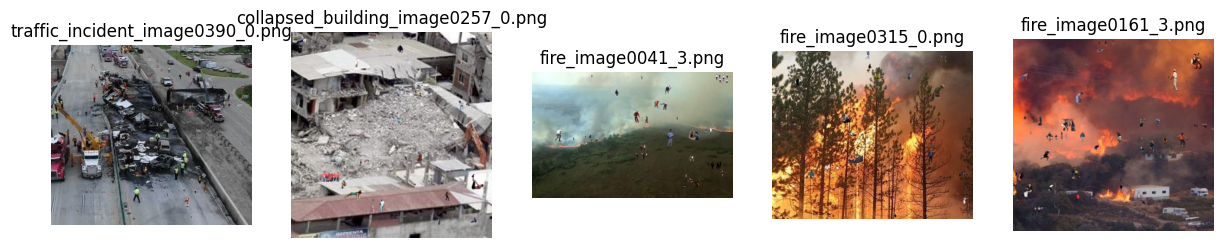

In [20]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def show_sample_images(image_dir, num_images=5):
    # Get all image paths
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.lower().endswith(('.jpg', '.png'))]
    
    # Pick random samples
    sample_paths = random.sample(image_paths, min(num_images, len(image_paths)))
    
    # Plot
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR -> RGB for matplotlib
        plt.subplot(1, len(sample_paths), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(img_path))
    plt.show()

# Example: Show 5 sample images from train set
show_sample_images("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images", num_images=5)


In [18]:
from tqdm import tqdm

In [19]:
from tqdm import tqdm 

def preprocess_images(image_dir):
    for img_path in tqdm(glob.glob(f"{image_dir}/*.jpg")):
        try:
            img = cv2.imread(img_path)
            if img is None:
                os.remove(img_path)
                continue
            img_resized = cv2.resize(img, (640, 640))
            cv2.imwrite(img_path, img_resized)
        except:
            os.remove(img_path)

preprocess_images("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images")
preprocess_images("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/images")
preprocess_images("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images")

print("Preprocessing complete: resized to 640x640 & cleaned corrupts.")

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Preprocessing complete: resized to 640x640 & cleaned corrupts.


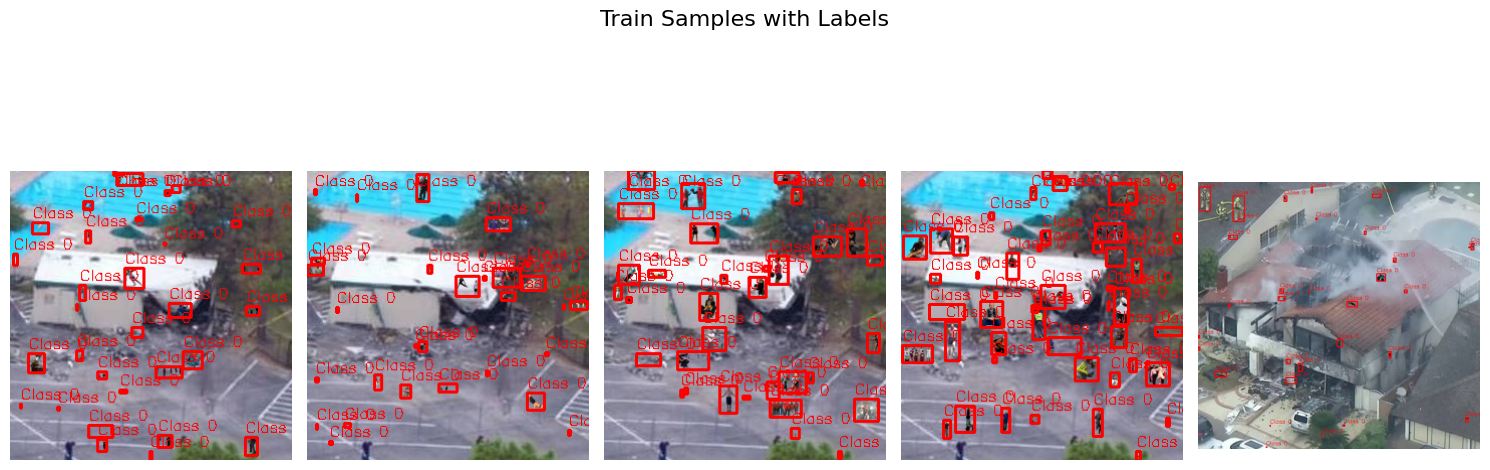

In [30]:
import os
import glob
import cv2
import matplotlib.pyplot as plt

def show_samples_with_labels(image_dir, label_dir, title):
    image_paths = sorted(glob.glob(f"{image_dir}/*.*"))
    plt.figure(figsize=(15, 6))
    plt.suptitle(title, fontsize=16)

    for i, img_path in enumerate(image_paths[:5]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Matching label file (works with .jpg/.png)
        label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + ".txt")
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    # Convert YOLO coords to pixels
                    x1 = int((x - bw / 2) * w)
                    y1 = int((y - bh / 2) * h)
                    x2 = int((x + bw / 2) * w)
                    y2 = int((y + bh / 2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, f"Class {int(cls)}", (x1, max(y1 - 5, 15)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Paths
base_path = "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3"

# Row 1: Just images
show_samples_with_labels(f"{base_path}/train/images", f"{base_path}/train/labels", "Train Samples with Labels")


In [6]:
import yaml

data_yaml = {
    'train': '/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images',
    'val': '/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/images',
    'test': '/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images',
    'nc': 4,  # number of classes (no "jumping")
    'names': [
        'standing',
        'sitting',
        'running',
        'walking'
    ]
}

# Save the yaml file
with open('c2a_data.yaml', 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("c2a_data.yaml created successfully")


c2a_data.yaml created successfully


In [ ]:
from kaggle_secrets import UserSecretsClient
import shutil

# Path of trained weights
weights_path = "runs/detect/train/weights/best.pt"

# Copy it to Kaggle output folder (so you can download)
shutil.copy(weights_path, "/kaggle/working/best.pt")

print(" Model copied to working directory. You can download it now.")


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths (update if different)
images_path = "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images"
labels_path = "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/labels"

# Class names (must match your yaml)
class_names = ["standing", "sitting", "running", "walking"]

def plot_image_with_labels(image_file):
    # Load image
    img_path = os.path.join(images_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Corresponding label file
    label_file = image_file.replace(".jpg", ".txt").replace(".png", ".txt")
    label_path = os.path.join(labels_path, label_file)

    if not os.path.exists(label_path):
        print(f"No label file for {image_file}")
        return

    # Read YOLO labels
    h, w, _ = img.shape
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, bw, bh = map(float, line.strip().split())
            cls = int(cls)

            # Convert YOLO format to pixel coordinates
            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)

            # Draw rectangle
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, class_names[cls], (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Show image
    plt.imshow(img)
    plt.axis("off")
    plt.show()


# Example: Show first 5 labeled images
for idx, img_file in enumerate(os.listdir(images_path)[:5]):
    print(f"Showing {img_file}...")
    plot_image_with_labels(img_file)
